# Air System Failure Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, recall_score, precision_score, confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
%load_ext watermark
%watermark --iversions

json      : 2.0.9
matplotlib: 3.8.0
numpy     : 1.26.4
IPython   : 8.20.0
sys       : 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
sklearn   : 1.2.2
pandas    : 2.1.4



Versions used on this project

## Loading Data

In [3]:
prev_years = pd.read_csv('data/air_system_previous_years.csv', na_values=['na'])
prev_years.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
prev_years.shape

(60000, 171)

In [5]:
prev_years['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

## Splitting in train/test data already

In [6]:
# We will be splitting the data into 80% of train data and 20% of test data. We are using random state. Lately we will use a k-fold validation anyways. 
train, test = train_test_split(prev_years, test_size=.2)

## Checking for missing values

In [7]:
missing_values = train.isna().sum()
missing_values

class         0
aa_000        0
ab_000    37028
ac_000     2657
ad_000    11897
          ...  
ee_007      528
ee_008      528
ee_009      528
ef_000     2173
eg_000     2172
Length: 171, dtype: int64

Our target columns doesn't have any missing value

In [8]:
missing_values_percentage = missing_values*100 / len(train)
missing_values_percentage.sort_values(ascending=False)[:20]

br_000    82.083333
bq_000    81.168750
bp_000    79.541667
bo_000    77.245833
ab_000    77.141667
cr_000    77.141667
bn_000    73.362500
bm_000    65.968750
bl_000    45.510417
bk_000    38.495833
ch_000    24.785417
co_000    24.785417
cg_000    24.785417
cf_000    24.785417
ad_000    24.785417
ct_000    23.037500
cu_000    23.037500
cv_000    23.037500
cx_000    23.037500
cy_000    23.037500
dtype: float64

In [9]:
# Amount of columns with a missing value
sum(missing_values != 0)

169

Almost all columns have a missing value

In [10]:
# Amount of rows with at least a missing value
sum(train.isna().sum(axis=1) != 0)

47542

Apparently we will need to automate the data cleaning process due to the large amount of columns with missing values

In [11]:
del missing_values
del missing_values_percentage

# Data preparation

### Data balancing (not used anymore)

In [12]:
# difference = len(train[train['class'] == 'neg']) - len(train[train['class'] == 'pos'])
# neg_indices_to_drop = np.random.choice(train[train['class'] == 'neg'].index, size=difference, replace=False)

# del difference

In [13]:
# train = train.drop(index=neg_indices_to_drop)

### Getting the features and the target

In [14]:
X_train, y_train = train.drop(columns=['class']), train['class']

### Creating the pipeline for preparing the data and reduce dimensionality

In [15]:
class ColumnSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)

In [16]:
# Dropping any column that has more than 50% of it's values missing
columns_to_drop = X_train.columns[X_train.isna().sum()/len(X_train) > .5]

In [17]:
# This pipeline will clean and scale our X train data.
transformer_pipeline = Pipeline([
    ('column_selector', ColumnSelection(columns_to_drop)),
    ('median_imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

transformer_pipeline.fit(X_train)

Pipeline(steps=[('column_selector',
                 ColumnSelection(columns=Index(['ab_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000',
       'cr_000'],
      dtype='object'))),
                ('median_imputer', SimpleImputer(strategy='median')),
                ('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=5))])

In [18]:
def preprocess_data(x, y, transformer_pipeline):
    '''Function that preprocess the features and the label data to automate the process'''
    x_preprocessed = transformer_pipeline.transform(x)
    y_preprocessed = np.where(y == 'neg', 0, 1)

    return x_preprocessed, y_preprocessed

In [19]:
# The name of remaining columns. (Necessary because x_preprocessed is a numpy array, i.e doesnt't have column names)
left_columns = X_train.drop(columns=columns_to_drop).columns

In [20]:
X_train_components, y_train = preprocess_data(X_train, y_train, transformer_pipeline)

In [21]:
X_train_components[:5, :5]

array([[-2.89934294,  0.27693126,  0.36502963,  0.15597178,  0.08646449],
       [-0.66410238, -0.26074517, -0.19715251, -0.04442777,  0.11206181],
       [-0.6704724 , -0.24333679, -0.20891443, -0.09285143,  0.08812489],
       [-0.54495388, -0.10602949, -0.54594847, -0.27603585,  0.11263709],
       [-2.98518837,  0.30115697,  0.61540368,  0.34146   , -0.2016066 ]])

Our train data features are already cleaned and scaled. The next step is to apply a dimensionality reduction algorithm so we can work with less columns and extract the feature importances.

## Analysis of the components

In [22]:
X_train_components

array([[-2.89934294,  0.27693126,  0.36502963,  0.15597178,  0.08646449],
       [-0.66410238, -0.26074517, -0.19715251, -0.04442777,  0.11206181],
       [-0.6704724 , -0.24333679, -0.20891443, -0.09285143,  0.08812489],
       ...,
       [-3.19338784,  0.19095258,  0.80556297,  0.29271765, -0.17223606],
       [-2.22598697,  0.3216673 ,  0.58662751,  0.26080717, -0.24767366],
       [ 6.2301697 , -1.06808842, -2.65110917, -2.09990019,  2.54770775]])

In [23]:
X_train_components.shape

(48000, 5)

In [24]:
pca = transformer_pipeline.named_steps['pca']
pca.explained_variance_

array([48.5455996 ,  7.88728396,  6.23680009,  5.08078673,  4.09966927])

In [25]:
most_important_index = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]

In [26]:
most_important_columns = left_columns[most_important_index]
most_important_columns

Index(['bx_000', 'ag_003', 'dt_000', 'ag_008', 'bj_000'], dtype='object')

In [27]:
for i in range(pca.n_components_):
    print(f"{most_important_columns[i]}: {pca.components_[i][most_important_index[i]]}")

bx_000: 0.13493620616696544
ag_003: 0.19511218679921177
dt_000: -0.22147344544857578
ag_008: 0.27197989685044477
bj_000: -0.2335348491963064


These are the most influent features for each principal component.

The first component explains almost 50% of the variation on the dataset, the second component explains 8% and so on.

## Machine Learning model building using Classification Algorithm

In [28]:
def evaluate_model(model, x=X_train_components, y=y_train):
    for i in ['recall', 'precision', 'accuracy']:
        skf = StratifiedKFold(n_splits=5)
        scores = cross_val_score(model, x, y, cv=skf, scoring=i)
        mean = scores.mean()
        std = scores.std()
        print("METRIC: {}\nSCORES: {}\nMEAN: {:.4f}\nSTD: {:.4f}\n".format(i, scores, mean, std))

In [29]:
def plot_roc_curve(models_dict, x=X_train_components, y=y_train):
    for model_name in models_dict:
        y_scores = cross_val_predict(models_dict[model_name], X_train_components, y_train, method='predict_proba')[:, 1]
        fpr, tpr, thresholds = roc_curve(y_train, y_scores)
        plt.plot(fpr, tpr, label=model_name)

    plt.plot(fpr, fpr, label="random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    plt.legend()
    plt.show()

In [30]:
# Benchmark Classifiers
dt_benchmark = DecisionTreeClassifier()
rf_benchmark = RandomForestClassifier()
log_benchmark = LogisticRegression()

In [31]:
evaluate_model(dt_benchmark, X_train_components, y_train)

METRIC: recall
SCORES: [0.58441558 0.55844156 0.5        0.56493506 0.51948052]
MEAN: 0.5455
STD: 0.0310

METRIC: precision
SCORES: [0.58333333 0.51204819 0.46625767 0.50632911 0.5483871 ]
MEAN: 0.5233
STD: 0.0398

METRIC: accuracy
SCORES: [0.98760417 0.98416667 0.98322917 0.98427083 0.98458333]
MEAN: 0.9848
STD: 0.0015



In [32]:
evaluate_model(log_benchmark)

METRIC: recall
SCORES: [0.25974026 0.22727273 0.19480519 0.30519481 0.23376623]
MEAN: 0.2442
STD: 0.0369

METRIC: precision
SCORES: [0.49382716 0.50724638 0.40540541 0.55294118 0.57142857]
MEAN: 0.5062
STD: 0.0579

METRIC: accuracy
SCORES: [0.98385417 0.9840625  0.9825     0.98489583 0.98489583]
MEAN: 0.9840
STD: 0.0009



In [33]:
evaluate_model(rf_benchmark)

METRIC: recall
SCORES: [0.53246753 0.56493506 0.42857143 0.47402597 0.52597403]
MEAN: 0.5052
STD: 0.0481

METRIC: precision
SCORES: [0.81443299 0.70434783 0.68041237 0.7037037  0.82474227]
MEAN: 0.7455
STD: 0.0612

METRIC: accuracy
SCORES: [0.9903125  0.98875    0.9878125  0.98833333 0.990625  ]
MEAN: 0.9892
STD: 0.0011



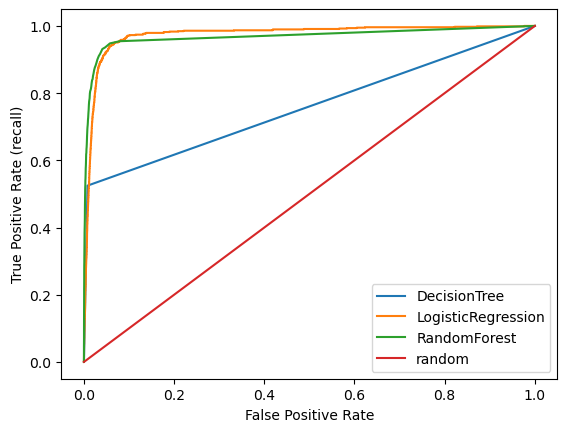

In [34]:
models_dict = {
    "DecisionTree": dt_benchmark,
    "LogisticRegression": log_benchmark,
    "RandomForest": rf_benchmark,
}
plot_roc_curve(models_dict)

Here we can see that RandomForest and LogisticRegression have the higher AUC. That means that if we want to raise the recall of our model, the fall rate of precision is low.

In [35]:
for model_name in models_dict:
    y_score = cross_val_predict(models_dict[model_name], X_train_components, y_train, method='predict_proba')[:, 1]
    auc = roc_auc_score(y_train, y_score)
    print("==============")
    print("{}\nAUC: {:.4f}\n".format(model_name, auc))

DecisionTree
AUC: 0.7636

LogisticRegression
AUC: 0.9747

RandomForest
AUC: 0.9710



## Hyperparameter Optimization

The model chosen to be tunned was the DecisionTreeClassifier due to his recall score close to the RandomForest and it's way less complexity and has a better hardware performance.

In [36]:
# rf_v1 = RandomForestClassifier(random_state=42)
dt_v1 = DecisionTreeClassifier(random_state=42)

In [37]:
param_grid = {
    # "n_estimators": [50, 100],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [20, 50, 150, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 4, 10],
    'class_weight': ['balanced']
}

In [38]:
random_search = RandomizedSearchCV(dt_v1, param_grid, scoring="recall")
random_search.fit(X_train_components, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [20, 50, 150, None],
                                        'min_samples_leaf': [1, 4, 10],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='recall')

In [39]:
random_search.best_score_

0.7974025974025973

In [40]:
random_search.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_depth': None,
 'criterion': 'log_loss',
 'class_weight': 'balanced'}

In [41]:
grid_search = GridSearchCV(dt_v1, param_grid, scoring="recall")
grid_search.fit(X_train_components, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [20, 50, 150, None],
                         'min_samples_leaf': [1, 4, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [42]:
grid_search.best_score_

0.7974025974025973

In [43]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [44]:
param_grid_2 = {
    # "n_estimators": [20, 50, 70],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 10],
    'class_weight': ['balanced']
}

In [45]:
random_search_2 = RandomizedSearchCV(dt_v1, param_grid_2, scoring="recall")
random_search_2.fit(X_train_components, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [5, 10, 20, None],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='recall')

In [46]:
random_search_2.best_score_

0.9415584415584416

In [47]:
random_search_2.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 5,
 'class_weight': 'balanced'}

In [48]:
grid_search_2 = GridSearchCV(dt_v1, param_grid_2, scoring="recall")
grid_search_2.fit(X_train_components, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [2, 4, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [49]:
grid_search_2.best_score_

0.9428571428571428

In [50]:
grid_search_2.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

## Final model building

In [51]:
best_params = {'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'class_weight': 'balanced'}

In [52]:
# model = RandomForestClassifier(**best_params, random_state=42)
model = DecisionTreeClassifier(**best_params)

In [53]:
model.fit(X_train_components, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [54]:
y_preds = model.predict(X_train_components)

In [55]:
recall_score(y_train, y_preds)

0.9727272727272728

In [56]:
precision_score(y_train, y_preds)

0.21436748712077847

In [57]:
confusion_matrix(y_train, y_preds)

array([[44485,  2745],
       [   21,   749]], dtype=int64)

As you can see, we opted to have a high recall score instead a high precision due to the cost of the false negatives. The model predicts more positives cases on the dataset because the false positives only costs $10 if it gets the prediction wrong.

## Business testing using the model

In [58]:
def model_report(y_true, y_pred, y_benchmark=None):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tp = ((y_pred == 1) & (y_true == 1)).sum()


    total_cost = fp*10 + fn*500 + tp*25
    unecessary_cost = total_cost - tp*25
    money_saved = (y_true == 1).sum()*500 - total_cost

    if y_benchmark is not None:
        recall_benchmark = recall_score(y_true, y_benchmark)
        precision_benchmark = precision_score(y_true, y_benchmark)
        
        fp_benchmark = ((y_benchmark == 1) & (y_true == 0)).sum()
        fn_benchmark = ((y_benchmark == 0) & (y_true == 1)).sum()
        tp_benchmark = ((y_benchmark == 1) & (y_true == 1)).sum()

        total_cost_benchmark = fp_benchmark*10 + fn_benchmark*500 + tp_benchmark*25
        unecessary_cost_benchmark = total_cost_benchmark - tp_benchmark*25
        money_saved_benchmark = (y_true == 1).sum()*500 - total_cost_benchmark

    print("====================")
    print("MODEL REPORT")
    print("Recall score: {:.4f}\nPrecision score: {:.4f}\n".format(recall, precision))
    print("Total cost spent: ${}\nUnnecessary Cost (model error): ${}\nMoney Saved With the Model: ${}".format(total_cost, unecessary_cost, money_saved))
    if y_benchmark is not None:
        print("--------------------")
        print("BENCHMARK")
        print("Recall score: {:.4f}\nPrecision score: {:.4f}\n".format(recall_benchmark, precision_benchmark))
        print("Total cost spent: ${}\nUnnecessary Cost (model error): ${}\nMoney Saved With the Model: ${}".format(total_cost_benchmark, unecessary_cost_benchmark, money_saved_benchmark))
    print("====================")

In [59]:
X_test, y_test = test.drop(columns=['class']), test['class']
X_test_components, y_test = preprocess_data(X_test, y_test, transformer_pipeline)

In [60]:
y_pred = model.predict(X_test_components)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [61]:
dt_benchmark.fit(X_train_components, y_train)

y_bench = dt_benchmark.predict(X_test_components)

In [62]:
model_report(y_test, y_pred, y_bench)

MODEL REPORT
Recall score: 0.9391
Precision score: 0.2424

Total cost spent: $19150
Unnecessary Cost (model error): $13750
Money Saved With the Model: $95850
--------------------
BENCHMARK
Recall score: 0.5609
Precision score: 0.5945

Total cost spent: $54605
Unnecessary Cost (model error): $51380
Money Saved With the Model: $60395


## Completed Model trained on the whole dataset

In [63]:
X_data, y_data = prev_years.drop(columns='class'), prev_years['class']

X_preprocessed, y_preprocessed = preprocess_data(X_data, y_data, transformer_pipeline)

In [64]:
model = DecisionTreeClassifier(**best_params)
model

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [65]:
evaluate_model(model, X_preprocessed, y_preprocessed)

METRIC: recall
SCORES: [0.935 0.95  0.915 0.95  0.965]
MEAN: 0.9430
STD: 0.0169

METRIC: precision
SCORES: [0.21618497 0.22144522 0.22648515 0.22538553 0.21758737]
MEAN: 0.2214
STD: 0.0041

METRIC: accuracy
SCORES: [0.94241667 0.9435     0.9465     0.94475    0.94158333]
MEAN: 0.9437
STD: 0.0017



In [66]:
model.fit(X_preprocessed, y_preprocessed)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

## Model persistence

In [67]:
with open('models/model_v1.pickle', 'wb') as file:
    pickle.dump(model, file)

with open('models/transformer_pipeline.pickle', 'wb') as file:
    pickle.dump(transformer_pipeline, file)

## Test on present year

In [68]:
pres_year = pd.read_csv('data/air_system_present_year.csv', na_values=['na'])

new_features, classes = pres_year.drop(columns='class'), pres_year['class']

new_features_preprocessed, classes_preprocessed = preprocess_data(new_features, classes, transformer_pipeline)

In [69]:
classes_preds = model.predict(new_features_preprocessed)

recall_score(classes_preprocessed, classes_preds)

0.9573333333333334

In [70]:
model_report(classes_preprocessed, classes_preds)

MODEL REPORT
Recall score: 0.9573
Precision score: 0.2945

Total cost spent: $25575
Unnecessary Cost (model error): $16600
Money Saved With the Model: $161925


Our model saved us **$161.925,00**!